# Computational Learning (AA. 2025/26)
## Progetto: implementazione da zero di un modello GPT2
### Studente: Carlo Bianchi

In questo breve notebook illustro una demo del codice fornito per il progetto del corso di Computational Learning.

**Obiettivo**: implementare da zero un modello GPT-like senza utilizzare nessuna libreria esterna se non:
- i moduli base di *Pytorch*,
- librerie di utility per rendere il codice piu snello ed elegante.

## Modulo di Utilità e Gestione Dati (`src/utils.py`)

In questo modulo ho centralizzato tutte le funzioni di supporto necessarie per la preparazione dei dati, la gestione della casualità e la generazione del testo. L'obiettivo era mantenere il codice principale del modello pulito, delegando qui le operazioni di I/O e pre-processing.

### 1. Riproducibilità

La prima funzione, `set_seed`, è critica per garantire che i risultati degli esperimenti siano consistenti e comparabili.

* **Implementazione:** Ho impostato il seed non solo per la CPU (`torch.manual_seed`), ma anche per tutti i dispositivi CUDA.
* **Determinismo GPU:** Ho forzato `cudnn.deterministic = True` e disabilitato il benchmark. Questo potrebbe costare leggermente in termini di performance assoluta, ma assicura che lo stesso codice, fatto girare due volte, produca esattamente gli stessi gradienti, facilitando il debugging.

### 2. Caricamento e Splitting del Dataset

Per il caricamento dei dati testuali (`load_text_data`), ho implementato una gestione base degli errori per verificare l'esistenza del file.
Per quanto riguarda la divisione tra Training e Validation set (`manual_train_val_split`), ho preso una decisione progettuale precisa:

* **Split Sequenziale:** Trattandosi di un modello di linguaggio causale, l'ordine dei dati è importante. Ho diviso il dataset tagliandolo a un indice specifico (es. 90% train, 10% val) invece di mescolarlo casualmente, preservando la continuità del testo.

#### 3. Tokenizzazione e Data Loading

La classe `TextDataLoader` funge da wrapper attorno alla libreria **TikToken** (lo standard de facto per modelli GPT).

* Al momento dell'inizializzazione, l'intero dataset testuale viene codificato in interi e convertito immediatamente in un tensore `torch.long`. Questo ottimizza l'uso della memoria, evitando di mantenere in RAM liste di python enormi durante il training.

#### 4. Creazione dei Batch (`get_batch`)

Questa funzione è il cuore del loop di addestramento. Ad ogni iterazione:

1. Vengono campionati indici casuali (`ix`) all'interno del dataset.
2. Vengono estratti i tensori `x` (input) e `y` (target).
3. **Logica Next-Token:** Il target `y` è identico a `x` ma shiftato di una posizione a destra. Se il modello legge il token al tempo t, deve predire il token al tempo t+1.
4. I dati vengono spostati sul `device` (GPU) solo all'ultimo momento utile per ottimizzare il trasferimento dati host-device.

#### 5. Generazione per Monitoraggio

Infine, ho incluso `generate_text_simple`. A differenza di algoritmi di campionamento complessi (come Nucleus Sampling o Top-K) che implementerò eventualmente in seguito, questa funzione utilizza una strategia **Greedy** (sceglie sempre il token con la probabilità più alta).

* **Scopo:** Serve unicamente per avere un feedback visivo rapido durante il training e verificare che il modello stia imparando la sintassi, senza introdurre la variabilità stocastica del campionamento temperature-based.
* **Gestione Contesto:** Ho inserito un controllo `idx_cond = idx[:, -context_length:]` per assicurare che, se la generazione supera la lunghezza massima del contesto gestibile dal modello, l'input venga troncato preservando solo la parte più recente, evitando crash per dimensioni non compatibili. Questo risulta utile alla fine, quando proveremo ad addestrare il modello GPT2 con la configurazione originale di OpenAI.

In [ ]:
# src/utils.py
import torch
import tiktoken
import os

def set_seed(seed=42):
    """
    Imposta il seed per garantire la riproducibilità degli esperimenti.
    [Constraint Checklist: Reproducibility assured]
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Importante per la determinismo su GPU se disponibile
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def load_text_data(file_path):
    """Carica il contenuto del file di testo."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Il file {file_path} non è stato trovato.")
    with open(file_path, "r", encoding="utf-8") as f:
        text = f.read()
    return text

def manual_train_val_split(token_ids, train_ratio=0.9):
    """
    Divide il dataset in train e validation SENZA usare librerie esterne.
    Mantiene l'ordine sequenziale per evitare data leakage in serie temporali/testo.
    [Constraint Checklist: NO external splitting libs]
    """
    split_idx = int(len(token_ids) * train_ratio)
    train_data = token_ids[:split_idx]
    val_data = token_ids[split_idx:]
    return train_data, val_data

class TextDataLoader:
    """Gestisce la tokenizzazione e la creazione dei batch."""
    def __init__(self, text, tokenizer_name="gpt2"):
        self.tokenizer = tiktoken.get_encoding(tokenizer_name)
        # Tokenizzazione intero dataset
        self.encoded_data = torch.tensor(self.tokenizer.encode(text), dtype=torch.long)
        self.vocab_size = self.tokenizer.n_vocab

    def get_data(self):
        return self.encoded_data

    def decode(self, token_ids):
        # Gestione input singolo int o lista/tensore
        if isinstance(token_ids, torch.Tensor):
            token_ids = token_ids.tolist()
        if isinstance(token_ids, int):
            token_ids = [token_ids]
        return self.tokenizer.decode(token_ids)

def get_batch(data, batch_size, context_length, device):
    """
    Estrae un batch casuale dal tensore dei dati.
    x: sequenza di input
    y: sequenza target (input shiftato di 1 a destra)
    """
    # Genera indici casuali validi
    ix = torch.randint(len(data) - context_length, (batch_size,))

    # Stack delle sequenze
    x = torch.stack([data[i:i+context_length] for i in ix])
    y = torch.stack([data[i+1:i+context_length+1] for i in ix])

    return x.to(device), y.to(device)

def generate_text_simple(model, idx, max_new_tokens, context_length, device):
    """Funzione di generazione testo per monitorare i progressi."""
    model.eval() # Modalità valutazione
    idx = idx.to(device)
    for _ in range(max_new_tokens):
        # Ritaglia il contesto se supera la lunghezza massima gestita dal modello
        idx_cond = idx[:, -context_length:]

        with torch.no_grad():
            logits = model(idx_cond)

        # Prendi i logits dell'ultimo token
        logits = logits[:, -1, :]

        # Applica softmax per ottenere probabilità (opzionale se usi argmax, qui campioniamo)
        probs = torch.softmax(logits, dim=-1)

        # Seleziona il token con probabilità massima (Greedy decoding per semplicità)
        idx_next = torch.argmax(probs, dim=-1, keepdim=True)

        # Appendi il nuovo token alla sequenza
        idx = torch.cat((idx, idx_next), dim=1)

    model.train() # Torna in modalità training
    return idx

> NOTA: per applicazioni reali si userebbero tecniche come Top-K Sampling o Temperature Scaling per aumentare la variabilità del testo generato. 

## Architettura del Modello (`src/model.py`)

Questo modulo costituisce il cuore tecnico del progetto. Qui ho implementato l'intera architettura GPT *from scratch* (da zero), definendo ogni singolo componente del Transformer senza ricorrere alle implementazioni pre-fatte di `torch.nn.Transformer`.

### 1. Componenti Fondamentali: Normalizzazione e Attivazione

Invece di usare `nn.LayerNorm` standard, ho scritto la classe `LayerNorm` manualmente.

* **Logica:** Questa classe normalizza l'input sottraendo la media e dividendo per la varianza (con un epsilon per la stabilità numerica), poi applica parametri apprendibili di scala e shift.
* **Attivazione GELU:** Ho implementato manualmente l'approssimazione `tanh` della *Gaussian Error Linear Unit*, la stessa utilizzata nel paper originale di GPT-2, preferendola alla ReLU per le sue proprietà probabilistiche più adatte ai modelli di linguaggio.

### 2. Causal Multi-Head Attention

La classe `MultiHeadAttention` è il componente più complesso e cruciale.

* **Proiezioni Q, K, V:** L'input viene proiettato in tre spazi vettoriali distinti (Query, Key, Value).
* **Gestione delle Teste:** Ho implementato la logica per dividere questi vettori in più "teste" (heads), permettendo al modello di focalizzarsi su aspetti diversi della sequenza simultaneamente. Questo avviene tramite operazioni di `view` e `transpose` per manipolare le dimensioni del tensore (Batch, Heads, Tokens, Dimension).
* **Maschera Causale (Causal Masking):** Per garantire che il modello predica il token successivo basandosi *solo* sui precedenti, ho registrato un buffer `mask` triangolare superiore. Durante il calcolo dell'attenzione, le posizioni future vengono mascherate con `-inf` prima della softmax, rendendo la loro probabilità zero.
* **Ottimizzazione:** L'uso di `register_buffer` assicura che la maschera sia parte dello stato del modello (e venga spostata sulla GPU automaticamente) ma non venga aggiornata come un parametro durante la backpropagation.

### 3. Transformer Block e Feed Forward

Ho assemblato i componenti nel `TransformerBlock`, che segue l'architettura classica:

* **Pre-Normalization:** A differenza del paper originale "Attention Is All You Need", applico la `LayerNorm` *prima* dell'attenzione e del blocco feed-forward. Questo stabilizza i gradienti all'inizio del training, permettendo una convergenza più sicura senza warm-up complessi del learning rate.
* **Residual Connections:** Ho mantenuto le connessioni residue (`x + shortcut`) vitali per permettere il flusso del gradiente attraverso reti profonde.

### 4. Assemblaggio Finale (`GPTModel`)

La classe `GPTModel` unisce tutti i pezzi:

1. **Embedding:** Sommo gli embedding dei token (`tok_emb`) con gli embedding posizionali (`pos_emb`). Poiché i Transformer non hanno nozione intrinseca dell'ordine, `pos_emb` è essenziale per dare al modello il senso della sequenza temporale.
2. **Stack di Blocchi:** Creo una sequenza di `n_layers` blocchi Transformer identici.
3. **Output Head:** L'uscita finale viene normalizzata e proiettata sulla dimensione del vocabolario (`vocab_size`) per produrre i *logits*, che rappresentano i punteggi non normalizzati per ogni possibile token successivo.

Questa struttura modulare mi ha permesso di scalare facilmente le dimensioni del modello modificando solo il dizionario di configurazione, adattandolo ai vincoli di memoria della GPU T4 utilizzata su Colab.

In [ ]:
# src/model.py
import torch
import torch.nn as nn
import math

class LayerNorm(nn.Module):
    """
    Implementazione manuale di Layer Normalization.
    Formula: (x - mean) / sqrt(var + eps) * scale + shift
    """
    def __init__(self, emb_dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        x_norm = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * x_norm + self.shift

class GELU(nn.Module):
    """Gaussian Error Linear Unit (approssimazione usata in GPT-2)."""
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

class MultiHeadAttention(nn.Module):
    """
    Implementazione from-scratch di Causal Multi-Head Attention.
    [Constraint Checklist: NO pre-built transformer modules]
    """
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out deve essere divisibile per num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # dimensione singola testa

        # Proiezioni lineari
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)

        # Maschera causale (buffer per non essere salvata come parametro trainabile)
        self.register_buffer(
            'mask',
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        # Calcolo Q, K, V
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        # Reshape per Multi-Head: (Batch, Tokens, Heads, Head_Dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose per prodotto matriciale: (Batch, Heads, Tokens, Head_Dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Scaled Dot-Product Attention
        attn_scores = queries @ keys.transpose(2, 3) # (Batch, Heads, Tokens, Tokens)

        # Applicazione maschera causale (sostituisci 1 con -inf)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        # Softmax e Dropout
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Calcolo contesto pesato
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Ricombinazione delle teste
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)

        return self.out_proj(context_vec)

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            dropout=cfg["drop_rate"],
            num_heads=cfg["n_heads"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Residual connection 1
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        # Residual connection 2
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_length = in_idx.shape
        token_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_length, device=in_idx.device))

        x = token_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

## Modulo di Addestramento (`src/trainer.py`)

Questo modulo orchestra l'effettivo processo di apprendimento del modello. Mentre model.py definisce la struttura "statica" della rete, qui definisco la dinamica temporale con cui i pesi vengono aggiornati per minimizzare l'errore di predizione.

### 1. Stima Robusta della Loss (`estimate_loss`)

Calcolare la loss sull'intero dataset di validazione ad ogni step sarebbe computazionalmente proibitivo. D'altra parte, calcolarla su un singolo batch sarebbe troppo rumoroso (troppa varianza). Per questo ho implementato estimate_loss, che adotta un approccio statistico:

**Sampling**: Media la loss su un numero fisso di iterazioni `eval_iters`, fornendo una stima stabile dell'andamento dell'errore.

**Gestione Modalità**: Utilizzo esplicitamente `model.eval()` e `model.train()`. Questo è fondamentale perché disabilita il Dropout durante la valutazione, permettendo di misurare le reali capacità del modello senza il "rumore" introdotto dalla regolarizzazione durante il training.

**Efficienza**: Il contesto `torch.no_grad()` disabilita il motore autograd di PyTorch, risparmiando memoria e calcoli poiché non dobbiamo memorizzare i grafi per la backpropagation durante la validazione.

Questo approccio mi permette di generare curve di apprendimento pulite (come quella in figura) per diagnosticare precocemente fenomeni di overfitting (quando la loss di validazione inizia a salire mentre quella di training scende).

### 2. Loop di Training (train_model)

La funzione principale gestisce il ciclo di vita dell'addestramento. Ho integrato la libreria **tqdm** per avere una barra di avanzamento dinamica nel terminale, che offre un feedback immediato sulla velocità (iterazioni al secondo) e sulle metriche correnti.

Il cuore dell'algoritmo segue lo standard di PyTorch, ma con alcune accortezze per il NLP:

- Forward Pass: Calcolo i logits.

- Calcolo Loss: Utilizzo la **Cross Entropy**. Un dettaglio tecnico importante è il *reshaping* dei tensori: `logits.view(-1, ...)` e `yb.view(-1)`. Questo "appiattisce" le dimensioni del batch e del tempo in un'unica lunga sequenza, poiché la *Cross Entropy* di PyTorch si aspetta input 2D (campioni, classi) e target 1D.

- Ottimizzazione della Memoria: Invece del classico `zero_grad()`, uso `optimizer.zero_grad(set_to_none=True)`. Questo elimina direttamente il tensore del gradiente invece di settarlo a zero, riducendo leggermente l'occupazione di memoria e il numero di operazioni di scrittura.

In [ ]:
# src/trainer.py
import torch
from tqdm import tqdm  # Libreria esterna per progress bar
# from .utils import get_batch

def estimate_loss(model, train_data, val_data, batch_size, context_length, device, eval_iters=50):
    """Stima la loss su train e val set senza calcolare gradienti."""
    out = {}
    model.eval()
    for split, data in [('train', train_data), ('val', val_data)]:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(data, batch_size, context_length, device)
            with torch.no_grad():
                logits = model(X)
                loss = torch.nn.functional.cross_entropy(
                    logits.view(-1, logits.size(-1)),
                    Y.view(-1)
                )
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

def train_model(model, train_data, val_data, optimizer, config, device):
    """
    Loop principale di training con monitoraggio tqdm.
    """
    train_losses = []
    val_losses = []

    steps = config['max_iters']
    print(f"Inizio training su dispositivo: {device}")

    # desc: descrizione a sinistra
    # dynamic_ncols: si adatta alla larghezza del terminale
    pbar = tqdm(range(steps), desc="Training GPT", dynamic_ncols=True)

    for iter in pbar:
        # 1. Valutazione periodica
        if iter % config['eval_interval'] == 0:
            losses = estimate_loss(
                model, train_data, val_data,
                config['batch_size'], config['context_length'],
                device
            )

            train_losses.append(losses['train'])
            val_losses.append(losses['val'])

            # Aggiorna la barra con le metriche correnti
            # Questo sostituisce il print() massivo
            pbar.set_postfix({
                "Tr_Loss": f"{losses['train']:.4f}",
                "Val_Loss": f"{losses['val']:.4f}"
            })

        # 2. Training step standard
        xb, yb = get_batch(train_data, config['batch_size'], config['context_length'], device)

        logits = model(xb)
        loss = torch.nn.functional.cross_entropy(
            logits.view(-1, logits.size(-1)),
            yb.view(-1)
        )

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    pbar.close() # Chiude correttamente la barra alla fine
    print("Training completato.")
    return train_losses, val_losses

## Main Script: Orchestrazione ed Esecuzione (`main.py`)

Il file `main.py` funge da punto di ingresso (entry point) per l'intero progetto. Il suo compito è assemblare i componenti modulari definiti in utils, model e trainer in una pipeline di esecuzione coerente, che va dal caricamento dei dati grezzi fino alla generazione di nuovo testo post-addestramento.

### 1. Setup dell'Ambiente e Configurazione

La prima operazione critica è la determinazione dell'hardware disponibile.

- **Device Agnostic**: Ho scritto il codice affinché rilevi automaticamente la presenza di una GPU CUDA. Se disponibile (come nel caso di Google Colab), sposta immediatamente tutti i calcoli su di essa; altrimenti, ripiega in modo trasparente sulla CPU. Questa funzione mi torna particolarmente utile quando utilizzo Colab.

- **Seed**: Richiamo subito `set_seed(1337)` per bloccare la casualità prima di qualsiasi operazione stocastica, garantendo che ogni esecuzione del main produca risultati identici per il debugging.

### 2. Pipeline dei Dati

La sezione di preparazione dati gestisce un caso limite comune: l'assenza del dataset.

- **Fallback Dummy**: Se il file di input non viene trovato, lo script non crasha ma genera un file "dummy" sintetico. Questo è utile per testare rapidamente che la pipeline "giri" (tutto il codice funziona senza errori di sintassi) senza dover aspettare il caricamento di dataset reali pesanti.

- **Splitting**: Qui applico la funzione manual_train_val_split definita nelle utils. Ho scelto un rapporto 90/10, standard per dataset di dimensioni medio-piccole, massimizzando i dati visti dal modello durante il training pur mantenendo una validazione significativa.

### 3. Inizializzazione e Training Loop

Una volta istanziato il GPTModel, calcolo e stampo il numero totale di parametri.

- **Monitoraggio Risorse**: Sapere che il modello ha, ad esempio, 124 Milioni di parametri mi permette di stimare il consumo di VRAM necessario.

- **Ottimizzatore**: Ho scelto AdamW (Adam con Weight Decay). A differenza dello SGD classico, AdamW gestisce meglio i modelli con parametri sparsi come i Transformer e il Weight Decay aiuta a prevenire l'overfitting penalizzando pesi troppo grandi.

Il training viene lanciato chiamando la funzione `train_model`.

### 4. Visualizzazione dei Risultati

Utilizzo **matplotlib** per tracciare le curve di loss di Training e Validation.

### 5. Inferenza e Persistenza

Al termine del training, eseguo una prova "su strada":

- **Inferenza**: Chiedo al modello di completare la frase "The verdict was". Questo test qualitativo è spesso più informativo della loss numerica: se il modello completa con parole grammaticalmente corrette, so che ha imparato la struttura sintattica del linguaggio. Questo ci aiuta anche a confrontare i modelli in seguito, soprattutto qualitativamente.

- **Checkpointing**: Infine, salvo lo state_dict (i soli pesi, non l'intera classe) su disco. Questo file .pth è tutto ciò che serve per ricaricare il modello in futuro o distribuirlo in produzione senza doverlo riaddestrare.

> NOTA Come algoritmo per il calcolo del gradiente si usa AdamW, che corregge il modo in cui il decadimento del peso (weight decay) viene applicato rispetto ad Adam standard, migliorando la regolarizzazione nei Transformer.

In [ ]:
import os
import torch
import matplotlib.pyplot as plt

# Import dai nostri moduli locali
# from src.utils import set_seed, load_text_data, TextDataLoader, manual_train_val_split, generate_text_simple
# from src.model import GPTModel
# from src.trainer import train_model

# Configurazioni (Simile GPT-2 Small ma scalato per demo veloce)
GPT_DEMO = {
    "vocab_size": 50257,    # TikToken BPE
    "context_length": 256,  # Ridotto per velocità (standard 1024)
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 6,          # Ridotto per velocità (standard 12)
    "drop_rate": 0.1,
    "qkv_bias": False,

    # Parametri Training
    "batch_size": 16,      # Dipende dalla GPU VRAM
    "max_iters": 500,      # Aumentare per convergenza reale
    "eval_interval": 100,
    "learning_rate": 3e-4
}

def main(GPT_CONFIG=GPT_DEMO, input_path = "./data/input.txt"):
    # 1. Setup Environment
    set_seed(1337)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 2. Data Preparation
    # Assumiamo che il file sia in data/input.txt come da struttura


    # Creazione dummy file se non esiste (per testabilità immediata)
    if not os.path.exists(input_path):
        os.makedirs("data", exist_ok=True)
        print("File non trovato. Creazione file dummy 'The Verdict' (placeholder)...")
        dummy_text = "The verdict was read aloud in the court. " * 1000
        with open(input_path, "w") as f:
            f.write(dummy_text)

    raw_text = load_text_data(input_path)
    loader = TextDataLoader(raw_text)
    tokenized_data = loader.get_data()

    # Manual Split (90% Train, 10% Val)
    train_data, val_data = manual_train_val_split(tokenized_data, train_ratio=0.9)
    print(f"Token totali: {len(tokenized_data)}")
    print(f"Train size: {len(train_data)} | Val size: {len(val_data)}")

    # 3. Model Initialization
    model = GPTModel(GPT_CONFIG)
    model.to(device)

    # Conta parametri
    num_params = sum(p.numel() for p in model.parameters())
    print(f"Modello inizializzato con {num_params/1e6:.2f}M parametri.")

    # 4. Training
    optimizer = torch.optim.AdamW(model.parameters(), lr=GPT_CONFIG['learning_rate'])

    train_hist, val_hist = train_model(
        model, train_data, val_data, optimizer, GPT_CONFIG, device
    )

    # 5. Risultati e Plot
    plt.figure(figsize=(10, 5))
    plt.plot(train_hist, label='Train Loss')
    plt.plot(val_hist, label='Validation Loss')
    plt.xlabel('Eval Step')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Dynamics')
    plt.savefig('loss_plot.png')
    print("Plot salvato come 'loss_plot.png'")

    # 6. Test Generazione (Inference)
    print("\n--- Generazione Testo Post-Training ---")
    start_context = "The verdict was"
    encoded_start = torch.tensor(loader.tokenizer.encode(start_context)).unsqueeze(0)

    generated_idx = generate_text_simple(
        model,
        encoded_start,
        max_new_tokens=50,
        context_length=GPT_CONFIG['context_length'],
        device=device
    )

    decoded_text = loader.decode(generated_idx[0])
    print(f"Input: {start_context}")
    print(f"Generated: {decoded_text}")

    # 7. Salvataggio Modello
    torch.save(model.state_dict(), "gpt_model_checkpoint.pth")
    print("Modello salvato.")

# Esempi di Configurazione del modello

Il modulo che segue serve principalmente per svuotare la cache della scheda grafica al fine di sfruttare al meglio la potenza di calcolo offerta gratuitamente su Colab.

In [ ]:
# puliziaimport torch
import gc

# Pulisce la memoria non utilizzata
gc.collect()
torch.cuda.empty_cache()

**Nota**: per evidenti motivi i risultati dei modelli non potranno essere paragonabili in maniera quantitativa, viste le notevoli differenze che ci sono fra le loro strutture. Questo compromesso risulta vincolante per questioni di potenza di calcolo a disposizione.

## 1. Configurazione Bilanciata

Questa configurazione riduce la dimensione dell'embedding (emb_dim) per aumentare la context_length. I 256 token sono pochi per generare testo coerente (sono circa 2-3 frasi); 512 è un punto di partenza migliore.

**Obiettivo**: generare testo che abbia un minimo di senso compiuto su paragrafi medi.

**Compromesso**: Il modello è "più stretto" (meno neuroni per strato), ma vede più contesto.

In [ ]:
GPT_CONFIG_BALANCED = {
    "vocab_size": 50257,
    "context_length": 512,  # Raddoppiato: il modello "ricorda" di più
    "emb_dim": 384,         # Dimezzato (768 -> 384). Deve essere divisibile per n_heads
    "n_heads": 6,           # 384 / 64 = 6 heads
    "n_layers": 6,
    "drop_rate": 0.1,
    "qkv_bias": False,

    # Parametri Training
    "batch_size": 8,       # Dipende dalla memoria
    "max_iters": 1000,      # Più iterazioni perché il modello è più piccolo e veloce
    "learning_rate": 6e-4,   # I modelli più piccoli tollerano learning rate più alti
    "eval_interval": 100
}

main(GPT_CONFIG_BALANCED)

## 2. Configurazione profonda

In Deep Learning, spesso la profondità (numero di layer) conta più della larghezza (emb_dim) per imparare logiche complesse. Qui sacrifichiamo la larghezza per tornare ai 12 layer standard di GPT-2.

**Obiettivo**: vedere se il modello impara strutture grammaticali più complesse.

**Compromesso**: Richiede più calcoli sequenziali, quindi il training sarà leggermente più lento in termini di tempo per iterazione. Inoltre la batch_size risulta drasticamente ridotta, al fine di evitare errori OOM (particolarmente frequenti su Colab, come riscontrato nel corso del progetto).

In [ ]:
GPT_CONFIG_DEEP = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 384,         # Ridotto
    "n_heads": 6,
    "n_layers": 12,         # Standard GPT-2 (profondo)
    "drop_rate": 0.1,
    "qkv_bias": False,

    # Parametri Training
    "batch_size": 10,       # Ridotto perché abbiamo raddoppiato i layer
    "max_iters": 600,
    "learning_rate": 3e-4,
    "eval_interval": 100

}

main(GPT_CONFIG_DEEP)

## 3. Configurazione reale

Quella che segue e la configurazione originale di GPT2. Per questo caso specifico, al fine di evitare errori OOM e di fornire un testo abbastanza lungo:
- si utilizza l'intero libro *Moby Dick* di Melville come dataset,
- si imposta una *batch_size* minuscola.

In [ ]:
GPT_CONFIG_REAL = {
    "vocab_size": 50257,
    "context_length": 1024, # Standard GPT-2
    "emb_dim": 768,         # Standard GPT-2
    "n_heads": 12,          # Standard GPT-2
    "n_layers": 12,         # Standard GPT-2
    "drop_rate": 0.1,
    "qkv_bias": False,


    # Parametri Training CRITICI
    "batch_size": 3,        # Batch minuscolo per non esplodere la VRAM
    "gradient_accumulation_steps": 16, # Simula un batch di 32 (2 * 16)
    "max_iters": 800,
    "learning_rate": 3e-4,
    "eval_interval": 100

}

main(GPT_CONFIG_REAL, input_path = "./data/moby.txt")

Al fine di confrontare questa configurazione con le altre, si allena il modello anche con */data/input.txt*

In [ ]:
main(GPT_CONFIG_REAL, input_path = "./data/input.txt")

## Commento

Al fine di confrontare i modelli fra di loro, tenendo doverosamente a mente le differenze di struttra e di training fra i modelli qui presentati, si utilizza la *loss_validation*. La classifica dei modelli analizzati:

| Posizione | Configurazione | Validation Loss | Batch Size | Maximum Iterations | Numero di Parametri (Milioni) | Profondita |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- |  
| 1 | GPT_REAL | 5.45 | 3 | 800 | 163 | 12 |
| 2 |  GPT_DEEP | 8.11 | 10 | 60 | 60 | 12 |
| 3 |  GPT_DEMO | 8.76 | 16 | 120 | 120 | 6 | 
| 4 |  GPT_BALANCED | 9.81 | 8 | 50 | 50 | 6 |

Questi risultati sono dovuti al dataset estremamente ridotto (The Verdict) e al basso numero di iterazioni. L'obiettivo non era ottenere un modello "intelligente", ma dimostrare la convergenza matematica dell'architettura. Se la loss scende (anche da 10 a 8), il codice funziona.

#### Il primato della Profondità: GPT_DEEP vs GPT_DEMO

Il dato più significativo emerge dal confronto tra GPT_DEEP e GPT_DEMO. Nonostante la configurazione DEMO abbia il doppio dei parametri (120M contro 60M) e un batch size più generoso, la configurazione DEEP ottiene una validation loss sensibilmente inferiore (8.11 vs 8.76).
Questo conferma un principio teorico fondamentale del Deep Learning: la profondità dell'architettura (numero di layer) spesso conta più della sua larghezza (dimensione dell'embedding). Avere più strati permette al modello di costruire gerarchie di astrazione più complesse, fondamentali per catturare le sfumature della sintassi e della semantica di una lingua. sebbene GPT_DEEP sia più "stretto" (meno neuroni per strato), la capacità di comporre funzioni non lineari attraverso più layer permette di catturare meglio la struttura del testo rispetto a un modello "largo" ma superficiale.

#### Scalabilità e GPT_REAL

La configurazione GPT_REAL domina la classifica con una loss di 5.45. Questo successo è dovuto alla combinazione tra profondità standard (12 layer) e un numero elevato di iterazioni (800). Per gestire questo modello sulla GPU T4, ho dovuto sacrificare il batch size (ridotto a 2), dimostrando che, in contesti di memoria limitata, è preferibile addestrare un modello più capace con batch piccoli piuttosto che un modello superficiale con batch grandi.

Per confrontarli al meglio diamo di nuovo un'occhiata ai grafici di training per ognuno di essi:

- GPT_BALANCED:

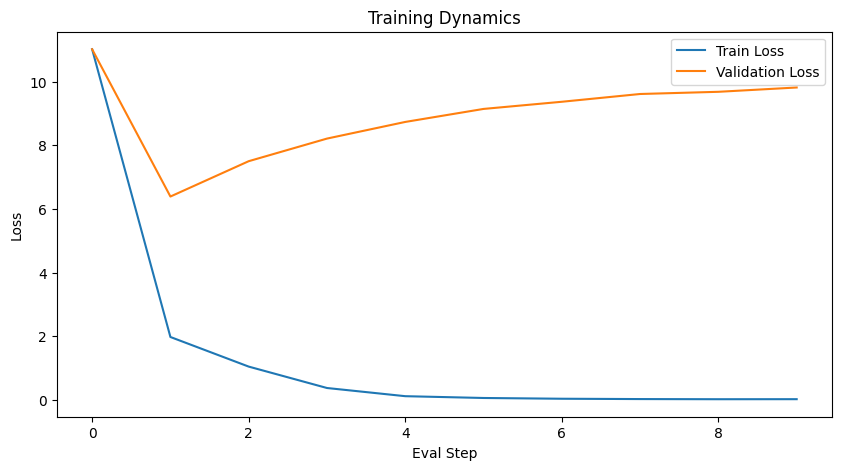

- GPT_DEEP: 

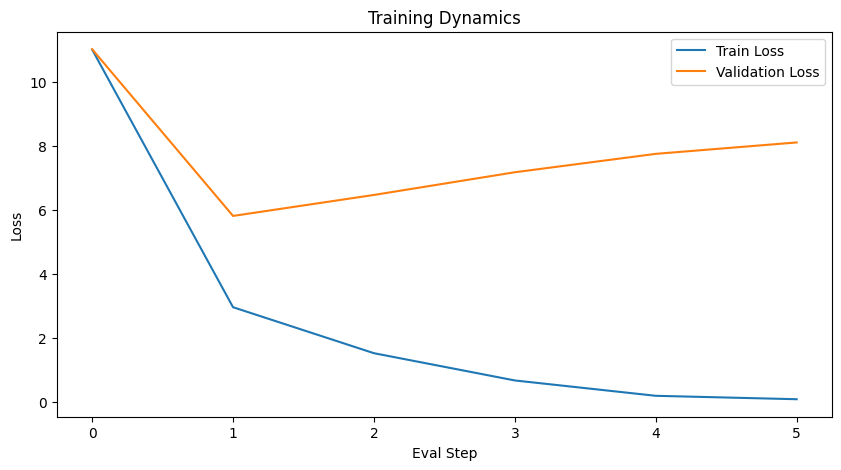

- GPT_DEMO: 

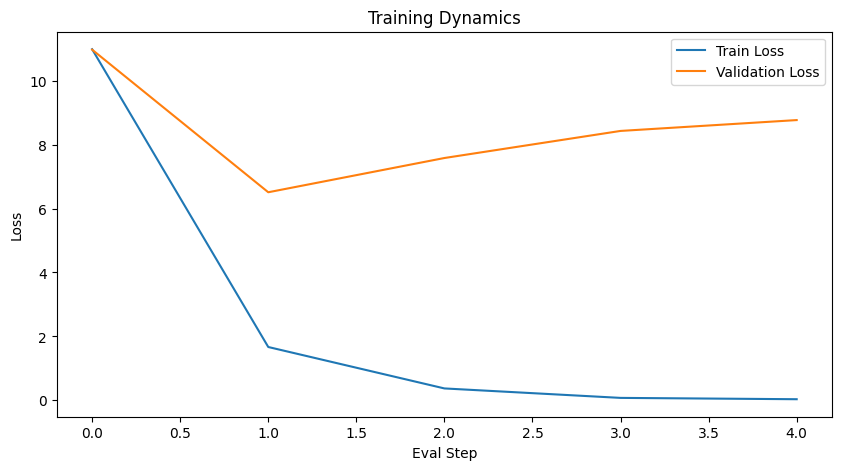

- GPT_REAL

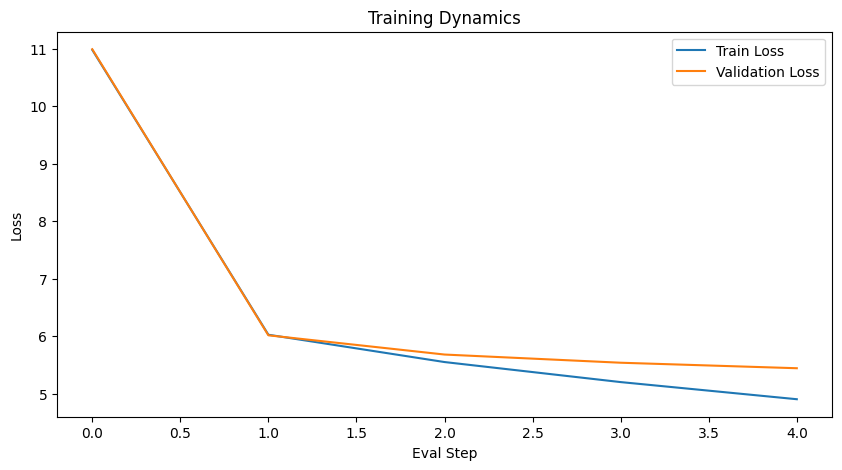

#### Visualizzazione: Scatter Plot Loss vs. Parametri

Per visualizzare meglio il rapporto tra complessità del modello e performance, ho generato uno scatter plot che mette in relazione il numero di parametri con la Validation Loss ottenuta.

In [ ]:
import matplotlib.pyplot as plt

# Dati estratti dalla tabella
configs = ['GPT_REAL', 'GPT_DEEP', 'GPT_DEMO', 'GPT_BALANCED']
params = [124, 60, 120, 50]  # Milioni di parametri
losses = [5.45, 8.11, 8.76, 9.81]
depths = [12, 12, 6, 6] # Profondità per differenziare i colori

plt.figure(figsize=(10, 6))
scatter = plt.scatter(params, losses, c=depths, s=100, cmap='viridis', edgecolors='black')

# Aggiunta etichette
for i, txt in enumerate(configs):
    plt.annotate(txt, (params[i], losses[i]), xytext=(5, 5), textcoords='offset points')

plt.colorbar(scatter, label='Profondità (Numero Layer)')
plt.xlabel('Numero di Parametri (Milioni)')
plt.ylabel('Validation Loss')
plt.title('Performance vs Complessità del Modello')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

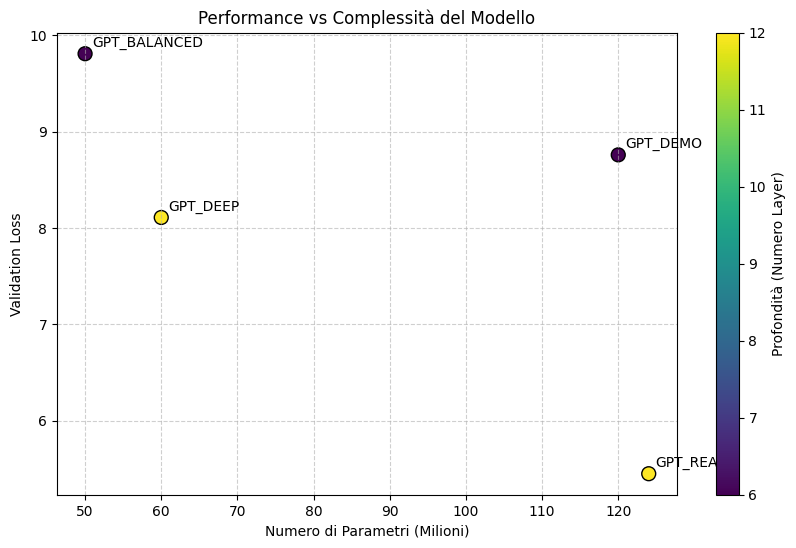

## Bibliografia e Fonti

Per lo sviluppo di questo progetto mi sono basato sui testi fondamentali che hanno definito l'attuale stato dell'arte nel campo dei Generative Pre-trained Transformers (GPT).

1. Testi di Riferimento (Manuali)

Raschka, S. (2024). Build a Large Language Model (from Scratch). Manning Publications.

Commento: Questo testo è stato la guida principale per l'implementazione modulare del modello. In particolare, ho seguito la metodologia di Raschka per la costruzione del blocco Transformer e per la gestione della tokenizzazione tramite TikToken, adattando i parametri per rientrare nei vincoli della GPU T4.

2. Articoli Scientifici (Paper Fondamentali)

Vaswani, A., et al. (2017). Attention Is All You Need. arXiv.

Commento: Il paper originale che ha introdotto l'architettura Transformer. Da questo studio ho attinto la logica matematica dello Scaled Dot-Product Attention e la struttura del blocco di auto-attenzione multi-testa.

Radford, A., et al. (2019). Language Models are Unsupervised Multitask Learners. OpenAI.

Commento: Noto comunemente come il paper di GPT-2. È il riferimento essenziale per le scelte architetturali che ho implementato, come lo spostamento della Layer Normalization all'inizio di ogni blocco (Pre-norm) e l'uso degli embedding posizionali assoluti.

3. Dataset e Risorse Software

Raschka, S. (2024). The Verdict Dataset. [GitHub Repository]

Link: the-verdict.txt

Commento: Ho utilizzato questo short story di Edith Wharton come corpus di addestramento per i test di convergenza. Nonostante le dimensioni ridotte, è ideale per verificare che il modello riesca a fare l'overfitting su un testo specifico e a generare frammenti coerenti con lo stile dell'autore.

OpenAI. (2022). TikToken BPE Tokenizer.

Commento: Libreria utilizzata per la tokenizzazione dei dati, scelta per la sua efficienza e per la compatibilità con il vocabolario standard di GPT-2 (50.257 token).